<a href="https://colab.research.google.com/github/Reis25/Analytics/blob/master/Deteccao_Defeitos_Garrafas_CocaCola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Defeitos em Garrafas de Coca-Cola com Deep Learning


## Objetivo
Detectar 8 tipos diferentes de defeitos em garrafas de Coca-Cola usando técnicas de Deep Learning.

## Tipos de Defeitos:
1. **CONTENT_HIGH**: Conteúdo acima do nível normal
2. **CONTENT_LOW**: Conteúdo abaixo do nível normal  
3. **COVER_NONE**: Sem tampa
4. **BOTTLE_SMASHED**: Garrafa amassada
5. **LABEL_WHITE**: Rótulo em branco
6. **LABEL_MISPLACED**: Rótulo fora do lugar
7. **LABEL_NONE**: Sem rótulo
8. **BOTTLE_NONE**: Sem garrafa

## Abordagem
- Classificação Multi-Label (uma imagem pode ter múltiplos defeitos)
- 3 Arquiteturas de Deep Learning:
  1. CNN Custom (baseline)
  2. ResNet50 (Transfer Learning)
  3. MobileNetV2 (Transfer Learning - leve)
- Dataset: 141 imagens de garrafas de Coca-Cola

---
## 1. Importação de Bibliotecas

In [ ]:
# Importações básicas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Keras e TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, MobileNetV2

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, hamming_loss

# Configurações
plt.style.use('ggplot')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("✓ Bibliotecas importadas com sucesso!")

TensorFlow version: 2.19.0
Keras version: 3.10.0
✓ Bibliotecas importadas com sucesso!


---
## 2. Configuração de Parâmetros

In [ ]:
# Parâmetros globais
IMG_HEIGHT = 120
IMG_WIDTH = 160  # Mantendo proporção das imagens originais
BATCH_SIZE = 16  # Menor devido ao dataset pequeno
NUM_CLASSES = 8  # 8 tipos de defeitos
EPOCHS = 100  # Mais épocas com early stopping
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
RANDOM_STATE = 42

# Caminhos
DATA_PATH = 'bottles/'
CSV_PATH = 'bottles/bottles_ground_truth.csv'

# Nomes das classes
CLASS_NAMES = [
    'CONTENT_HIGH', 'CONTENT_LOW', 'COVER_NONE', 'BOTTLE_SMASHED',
    'LABEL_WHITE', 'LABEL_MISPLACED', 'LABEL_NONE', 'BOTTLE_NONE'
]

print("Configurações:")
print(f"  Dimensões: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  Número de classes: {NUM_CLASSES}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Épocas máximas: {EPOCHS}")
print(f"\n  Classes: {CLASS_NAMES}")

Configurações:
  Dimensões: 120x160
  Número de classes: 8
  Batch size: 16
  Épocas máximas: 100

  Classes: ['CONTENT_HIGH', 'CONTENT_LOW', 'COVER_NONE', 'BOTTLE_SMASHED', 'LABEL_WHITE', 'LABEL_MISPLACED', 'LABEL_NONE', 'BOTTLE_NONE']


---
## 3. Carregamento e Preparação dos Dados

**IMPORTANTE:** Este é um problema de classificação **MULTI-LABEL** - uma imagem pode ter múltiplos defeitos simultaneamente.

In [ ]:
print("Carregando dados...\n")

# Ler CSV com ground truth
df = pd.read_csv(CSV_PATH, sep=';')

# Substituir NaN por 0 e manter 1 onde há defeito
df = df.fillna(0)

# Converter colunas de defeitos para inteiros
for col in CLASS_NAMES:
    df[col] = df[col].astype(int)

print(f"✓ Ground truth carregado: {len(df)} imagens")
print(f"\nPrimeiras linhas do dataset:")
print(df.head())

# Verificar quais imagens existem
available_images = [f for f in os.listdir(DATA_PATH) if f.endswith('.jpg')]
print(f"\n✓ Imagens disponíveis: {len(available_images)}")

# Filtrar apenas imagens que existem
df = df[df['IMAGE'].isin(available_images)]
print(f"✓ Imagens válidas após filtro: {len(df)}")

Carregando dados...

✓ Ground truth carregado: 141 imagens

Primeiras linhas do dataset:
          IMAGE  CONTENT_HIGH  CONTENT_LOW  COVER_NONE  BOTTLE_SMASHED  \
0  image001.jpg             1            0           0               0   
1  image002.jpg             0            0           0               0   
2  image003.jpg             0            0           0               0   
3  image004.jpg             0            0           0               0   
4  image005.jpg             0            0           0               0   

   LABEL_WHITE  LABEL_MISPLACED  LABEL_NONE  BOTTLE_NONE  
0            0                0           0            0  
1            0                0           0            0  
2            0                0           0            0  
3            0                0           0            0  
4            0                0           0            0  

✓ Imagens disponíveis: 141
✓ Imagens válidas após filtro: 141


In [ ]:
# Carregar imagens
def load_images_and_labels(df, data_path, img_height, img_width):
    """
    Carrega imagens e labels para classificação multi-label.
    """
    images = []
    labels = []

    print("Carregando imagens...")
    for idx, row in df.iterrows():
        img_name = row['IMAGE']
        img_path = os.path.join(data_path, img_name)

        try:
            # Carregar e redimensionar imagem
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_width, img_height), Image.LANCZOS)
            img_array = np.array(img)

            # Label multi-hot encoding
            label = row[CLASS_NAMES].values.astype(float)

            images.append(img_array)
            labels.append(label)

            if (idx + 1) % 20 == 0:
                print(f"  Carregadas {idx + 1}/{len(df)} imagens...")

        except Exception as e:
            print(f"  ⚠️  Erro ao carregar {img_name}: {e}")

    return np.array(images), np.array(labels)

# Carregar dados
X, y = load_images_and_labels(df, DATA_PATH, IMG_HEIGHT, IMG_WIDTH)

print(f"\n✓ Dados carregados com sucesso!")
print(f"  Shape de X: {X.shape}")
print(f"  Shape de y: {y.shape}")
print(f"  Range de pixels: [{X.min()}, {X.max()}]")

Carregando imagens...
  Carregadas 20/141 imagens...
  Carregadas 40/141 imagens...
  Carregadas 60/141 imagens...
  Carregadas 80/141 imagens...
  Carregadas 100/141 imagens...
  Carregadas 120/141 imagens...
  Carregadas 140/141 imagens...

✓ Dados carregados com sucesso!
  Shape de X: (141, 120, 160, 3)
  Shape de y: (141, 8)
  Range de pixels: [0, 255]


---
## 4. Análise Exploratória dos Dados

In [ ]:
print("="*80)
print("ANÁLISE EXPLORATÓRIA DOS DADOS")
print("="*80)

# 1. Informações básicas
print(f"\n1. INFORMAÇÕES BÁSICAS")
print(f"   Total de imagens: {len(X)}")
print(f"   Dimensões: {X.shape[1]}x{X.shape[2]} pixels")
print(f"   Número de defeitos possíveis: {NUM_CLASSES}")

# 2. Distribuição de defeitos
print(f"\n2. DISTRIBUIÇÃO DE DEFEITOS (MULTI-LABEL)")
defect_counts = y.sum(axis=0)
for i, class_name in enumerate(CLASS_NAMES):
    count = int(defect_counts[i])
    percentage = 100 * count / len(y)
    print(f"   {class_name:20s}: {count:3d} imagens ({percentage:5.1f}%)")

# 3. Número de defeitos por imagem
defects_per_image = y.sum(axis=1)
print(f"\n3. DEFEITOS POR IMAGEM")
print(f"   Média: {defects_per_image.mean():.2f} defeitos/imagem")
print(f"   Mínimo: {int(defects_per_image.min())} defeitos")
print(f"   Máximo: {int(defects_per_image.max())} defeitos")
print(f"   Imagens SEM defeitos: {(defects_per_image == 0).sum()}")
print(f"   Imagens COM defeitos: {(defects_per_image > 0).sum()}")

ANÁLISE EXPLORATÓRIA DOS DADOS

1. INFORMAÇÕES BÁSICAS
   Total de imagens: 141
   Dimensões: 120x160 pixels
   Número de defeitos possíveis: 8

2. DISTRIBUIÇÃO DE DEFEITOS (MULTI-LABEL)
   CONTENT_HIGH        :  39 imagens ( 27.7%)
   CONTENT_LOW         :  12 imagens (  8.5%)
   COVER_NONE          :  15 imagens ( 10.6%)
   BOTTLE_SMASHED      :  11 imagens (  7.8%)
   LABEL_WHITE         :  13 imagens (  9.2%)
   LABEL_MISPLACED     :  12 imagens (  8.5%)
   LABEL_NONE          :  11 imagens (  7.8%)
   BOTTLE_NONE         :  12 imagens (  8.5%)

3. DEFEITOS POR IMAGEM
   Média: 0.89 defeitos/imagem
   Mínimo: 0 defeitos
   Máximo: 3 defeitos
   Imagens SEM defeitos: 51
   Imagens COM defeitos: 90


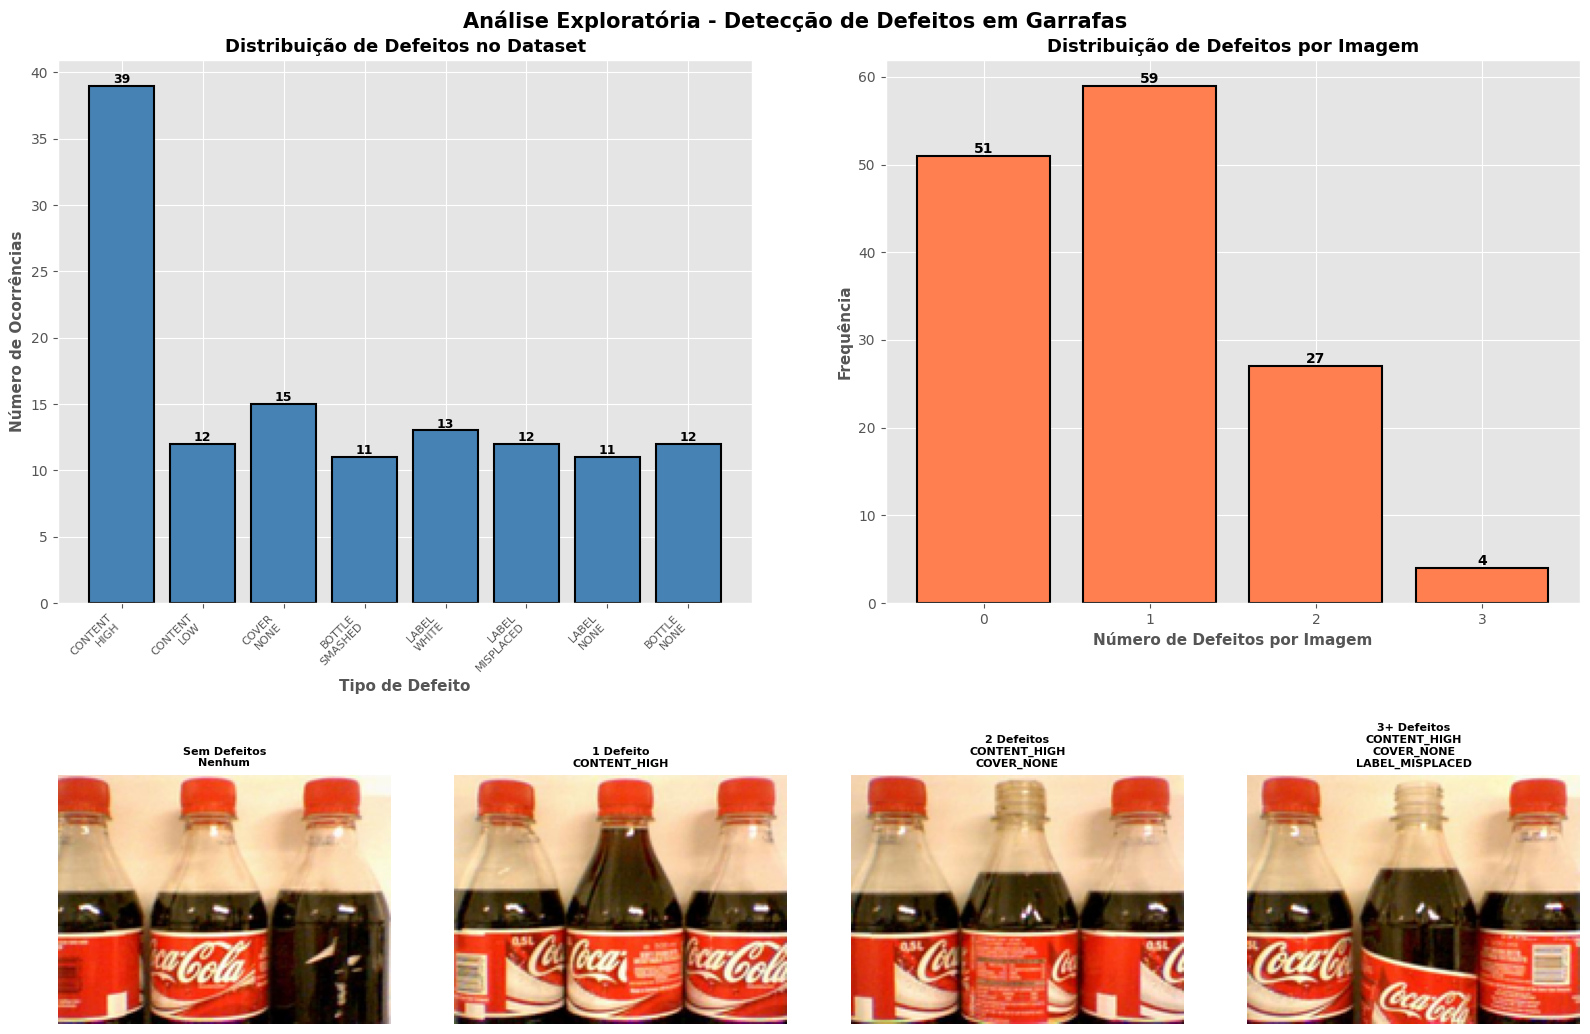


✓ Visualizações salvas: eda_garrafas_cocacola.png


In [ ]:
# Visualizações
fig = plt.figure(figsize=(16, 12))

# Subplot 1: Distribuição de defeitos
ax1 = plt.subplot(2, 2, 1)
bars = ax1.bar(range(NUM_CLASSES), defect_counts, color='steelblue',
               edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Tipo de Defeito', fontsize=11, fontweight='bold')
ax1.set_ylabel('Número de Ocorrências', fontsize=11, fontweight='bold')
ax1.set_title('Distribuição de Defeitos no Dataset', fontsize=13, fontweight='bold')
ax1.set_xticks(range(NUM_CLASSES))
ax1.set_xticklabels([name.replace('_', '\n') for name in CLASS_NAMES],
                     rotation=45, ha='right', fontsize=8)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Subplot 2: Defeitos por imagem
ax2 = plt.subplot(2, 2, 2)
unique_counts, freq = np.unique(defects_per_image, return_counts=True)
ax2.bar(unique_counts, freq, color='coral', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Número de Defeitos por Imagem', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequência', fontsize=11, fontweight='bold')
ax2.set_title('Distribuição de Defeitos por Imagem', fontsize=13, fontweight='bold')
ax2.set_xticks(unique_counts)
for i, v in enumerate(freq):
    ax2.text(unique_counts[i], v, str(v), ha='center', va='bottom',
            fontweight='bold', fontsize=10)

# Subplot 3 e 4: Exemplos de imagens
# Mostrar imagens com diferentes números de defeitos
ax3 = plt.subplot(2, 4, 5)
ax4 = plt.subplot(2, 4, 6)
ax5 = plt.subplot(2, 4, 7)
ax6 = plt.subplot(2, 4, 8)

examples_axes = [ax3, ax4, ax5, ax6]
examples_labels = [
    'Sem Defeitos',
    '1 Defeito',
    '2 Defeitos',
    '3+ Defeitos'
]
examples_conditions = [
    defects_per_image == 0,
    defects_per_image == 1,
    defects_per_image == 2,
    defects_per_image >= 3
]

for ax, label, condition in zip(examples_axes, examples_labels, examples_conditions):
    if condition.sum() > 0:
        idx = np.where(condition)[0][0]
        ax.imshow(X[idx])

        # Identificar defeitos presentes
        defects = [CLASS_NAMES[i] for i, val in enumerate(y[idx]) if val == 1]
        defects_str = '\n'.join(defects) if defects else 'Nenhum'

        ax.set_title(f"{label}\n{defects_str}", fontsize=8, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=20)
        ax.set_title(label, fontsize=9, fontweight='bold')

    ax.axis('off')

plt.suptitle('Análise Exploratória - Detecção de Defeitos em Garrafas',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('eda_garrafas_cocacola.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizações salvas: eda_garrafas_cocacola.png")

---
## 5. Divisão e Preparação dos Dados

In [ ]:
# Divisão estratificada para multi-label
# Usaremos a primeira label como referência para estratificação
stratify_col = y[:, 0]

# Primeira divisão: Treino+Val (80%) e Teste (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_col
)

# Segunda divisão: Treino (64%) e Validação (16%)
stratify_col_val = y_train_val[:, 0]
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE, stratify=stratify_col_val
)

print("Divisão dos dados:")
print(f"  Treino:     {X_train.shape[0]} imagens ({100*len(X_train)/len(X):.1f}%)")
print(f"  Validação:  {X_val.shape[0]} imagens ({100*len(X_val)/len(X):.1f}%)")
print(f"  Teste:      {X_test.shape[0]} imagens ({100*len(X_test)/len(X):.1f}%)")

# Normalização
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("\n✓ Dados normalizados (0-1)")
print(f"✓ Labels mantidas em formato multi-hot (shape: {y_train.shape})")

Divisão dos dados:
  Treino:     89 imagens (63.1%)
  Validação:  23 imagens (16.3%)
  Teste:      29 imagens (20.6%)

✓ Dados normalizados (0-1)
✓ Labels mantidas em formato multi-hot (shape: (89, 8))


---
## 6. Data Augmentation

In [ ]:
# Data Augmentation para treino (importante com dataset pequeno!)
train_datagen = ImageDataGenerator(
    rotation_range=10,  # Garrafas ficam quase sempre na vertical
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,  # Garrafas não devem ser espelhadas
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],  # Variação de iluminação
    fill_mode='nearest'
)

print("✓ Data Augmentation configurado")
print("  Transformações:")
print("    - Rotação: ±10°")
print("    - Deslocamento: ±10%")
print("    - Zoom: ±10%")
print("    - Brilho: 80-120%")

✓ Data Augmentation configurado
  Transformações:
    - Rotação: ±10°
    - Deslocamento: ±10%
    - Zoom: ±10%
    - Brilho: 80-120%


---
## 7. Callbacks

In [ ]:
# Callbacks para otimização do treinamento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, reduce_lr]

print("✓ Callbacks configurados")

✓ Callbacks configurados


---
# MODELO 1: CNN Custom (Baseline)

**IMPORTANTE:** Para classificação multi-label, usamos:
- Loss: `binary_crossentropy` (não categorical)
- Ativação final: `sigmoid` (não softmax)
- Cada neurônio de saída é independente

In [ ]:
print("="*80)
print("MODELO 1: CNN CUSTOM (BASELINE)")
print("="*80)

model_cnn = Sequential([
    # Bloco 1
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloco 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloco 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Classificador
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')  # SIGMOID para multi-label!
], name='CNN_Custom')

# Compilar com binary_crossentropy para multi-label
model_cnn.compile(
    loss='binary_crossentropy',  # Não categorical!
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', 'AUC']
)

print("\nArquitetura:")
model_cnn.summary()

print("\n🎯 Configurado para classificação MULTI-LABEL")
print("   Loss: binary_crossentropy")
print("   Ativação final: sigmoid")

MODELO 1: CNN CUSTOM (BASELINE)

Arquitetura:


Model: "CNN_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 120, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,830,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,972,136 (38.04 MB)

 Trainable params: 9,972,136 (38.04 MB)

 Non-trainable params: 0 (0.00 B)


🎯 Configurado para classificação MULTI-LABEL
   Loss: binary_crossentropy
   Ativação final: sigmoid


In [ ]:
# Treinar CNN Custom
print("Iniciando treinamento...\n")

history_cnn = model_cnn.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Treinamento concluído!")

Iniciando treinamento...

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - AUC: 0.4637 - accuracy: 0.1924 - loss: 0.6181 - val_AUC: 0.5000 - val_accuracy: 0.5217 - val_loss: 2.2866 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - AUC: 0.5481 - accuracy: 0.4391 - loss: 0.4204 - val_AUC: 0.5816 - val_accuracy: 0.5217 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - AUC: 0.6409 - accuracy: 0.4746 - loss: 0.3789 - val_AUC: 0.5866 - val_accuracy: 0.5217 - val_loss: 0.6209 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - AUC: 0.5938 - accuracy: 0.4423 - loss: 0.3361 - val_AUC: 0.5626 - val_accuracy: 0.5217 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - AUC: 0.5955 - accuracy: 0.5258 - loss: 0.3471 - val_AUC: 0.5607 - val_accuracy: 0.5217 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - AUC: 0.6386 - accu

In [ ]:
# Avaliar no teste
test_loss_cnn, test_acc_cnn, test_auc_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)  # Threshold 0.5

print("\n" + "="*80)
print("RESULTADOS - CNN CUSTOM")
print("="*80)
print(f"Loss:     {test_loss_cnn:.4f}")
print(f"Accuracy: {test_acc_cnn:.4f} ({test_acc_cnn*100:.2f}%)")
print(f"AUC:      {test_auc_cnn:.4f}")

# Hamming Loss (para multi-label)
hamming = hamming_loss(y_test, y_pred_cnn_binary)
print(f"Hamming Loss: {hamming:.4f} (quanto menor, melhor)")

# Relatório por classe
print("\nRelatório por Defeito:")
for i, class_name in enumerate(CLASS_NAMES):
    precision = (y_test[:, i] * y_pred_cnn_binary[:, i]).sum() / max(y_pred_cnn_binary[:, i].sum(), 1)
    recall = (y_test[:, i] * y_pred_cnn_binary[:, i]).sum() / max(y_test[:, i].sum(), 1)
    print(f"  {class_name:20s}: Precision={precision:.3f}, Recall={recall:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step

RESULTADOS - CNN CUSTOM
Loss:     0.3078
Accuracy: 0.6897 (68.97%)
AUC:      0.5711
Hamming Loss: 0.0948 (quanto menor, melhor)

Relatório por Defeito:
  CONTENT_HIGH        : Precision=0.000, Recall=0.000
  CONTENT_LOW         : Precision=0.000, Recall=0.000
  COVER_NONE          : Precision=0.000, Recall=0.000
  BOTTLE_SMASHED      : Precision=0.000, Recall=0.000
  LABEL_WHITE         : Precision=0.000, Recall=0.000
  LABEL_MISPLACED     : Precision=0.000, Recall=0.000
  LABEL_NONE          : Precision=0.000, Recall=0.000
  BOTTLE_NONE         : Precision=0.000, Recall=0.000


---
# MODELO 2: ResNet50 (Transfer Learning)

In [ ]:
print("="*80)
print("MODELO 2: RESNET50 (TRANSFER LEARNING)")
print("="*80)

base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model_resnet.trainable = False

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')  # SIGMOID para multi-label
], name='ResNet50_TL')

model_resnet.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy', 'AUC']
)

print("\nArquitetura:")
model_resnet.summary()
print(f"\nCamadas congeladas: {len(base_model_resnet.layers)}")

MODELO 2: RESNET50 (TRANSFER LEARNING)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Arquitetura:


Model: "ResNet50_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Camadas congeladas: 175


In [ ]:
# Treinar ResNet50
print("Iniciando treinamento...\n")

history_resnet = model_resnet.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Treinamento concluído!")

Iniciando treinamento...

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - AUC: 0.5138 - accuracy: 0.1548 - loss: 0.7996 - val_AUC: 0.4421 - val_accuracy: 0.0870 - val_loss: 0.6986 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - AUC: 0.4802 - accuracy: 0.1264 - loss: 0.7460 - val_AUC: 0.4517 - val_accuracy: 0.0870 - val_loss: 0.6383 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - AUC: 0.5028 - accuracy: 0.0643 - loss: 0.6824 - val_AUC: 0.4904 - val_accuracy: 0.0870 - val_loss: 0.5876 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - AUC: 0.4887 - accuracy: 0.1406 - loss: 0.6407 - val_AUC: 0.5184 - val_accuracy: 0.0870 - val_loss: 0.5458 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - AUC: 0.4374 - accuracy: 0.1327 - loss: 0.6058 - val_AUC: 0.5598 - val_accuracy: 0.5652 - val_loss: 0.5117 - learning_rate: 1.0000e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - AU

In [ ]:
# Avaliar
test_loss_resnet, test_acc_resnet, test_auc_resnet = model_resnet.evaluate(X_test, y_test, verbose=0)
y_pred_resnet = model_resnet.predict(X_test)
y_pred_resnet_binary = (y_pred_resnet > 0.5).astype(int)

print("\n" + "="*80)
print("RESULTADOS - RESNET50")
print("="*80)
print(f"Loss:     {test_loss_resnet:.4f}")
print(f"Accuracy: {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")
print(f"AUC:      {test_auc_resnet:.4f}")
print(f"Hamming Loss: {hamming_loss(y_test, y_pred_resnet_binary):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

RESULTADOS - RESNET50
Loss:     0.2988
Accuracy: 0.6897 (68.97%)
AUC:      0.6608
Hamming Loss: 0.0948


---
# MODELO 3: MobileNetV2 (Transfer Learning - Leve)

In [ ]:
print("="*80)
print("MODELO 3: MOBILENETV2 (TRANSFER LEARNING - LEVE)")
print("="*80)

base_model_mobile = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model_mobile.trainable = False

model_mobile = Sequential([
    base_model_mobile,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='sigmoid')
], name='MobileNetV2_TL')

model_mobile.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy', 'AUC']
)

print("\nArquitetura:")
model_mobile.summary()
print(f"Parâmetros: {model_mobile.count_params():,}")

MODELO 3: MOBILENETV2 (TRANSFER LEARNING - LEVE)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Arquitetura:


Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Parâmetros: 2,422,984


In [ ]:
# Treinar MobileNetV2
print("Iniciando treinamento...\n")

history_mobile = model_mobile.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Treinamento concluído!")

Iniciando treinamento...

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - AUC: 0.3518 - accuracy: 0.0969 - loss: 0.7171 - val_AUC: 0.5484 - val_accuracy: 0.1304 - val_loss: 0.5086 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - AUC: 0.4338 - accuracy: 0.1147 - loss: 0.6463 - val_AUC: 0.5652 - val_accuracy: 0.1304 - val_loss: 0.4521 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - AUC: 0.6168 - accuracy: 0.2317 - loss: 0.5697 - val_AUC: 0.5685 - val_accuracy: 0.1304 - val_loss: 0.4206 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - AUC: 0.5149 - accuracy: 0.2264 - loss: 0.5405 - val_AUC: 0.5639 - val_accuracy: 0.0435 - val_loss: 0.4094 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - AUC: 0.4906 - accuracy: 0.3201 - loss: 0.5114 - val_AUC: 0.5638 - val_accuracy: 0.0435 - val_loss: 0.4064 - learning_rate: 1.0000e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
# Avaliar
test_loss_mobile, test_acc_mobile, test_auc_mobile = model_mobile.evaluate(X_test, y_test, verbose=0)
y_pred_mobile = model_mobile.predict(X_test)
y_pred_mobile_binary = (y_pred_mobile > 0.5).astype(int)

print("\n" + "="*80)
print("RESULTADOS - MOBILENETV2")
print("="*80)
print(f"Loss:     {test_loss_mobile:.4f}")
print(f"Accuracy: {test_acc_mobile:.4f} ({test_acc_mobile*100:.2f}%)")
print(f"AUC:      {test_auc_mobile:.4f}")
print(f"Hamming Loss: {hamming_loss(y_test, y_pred_mobile_binary):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

RESULTADOS - MOBILENETV2
Loss:     0.3467
Accuracy: 0.0000 (0.00%)
AUC:      0.5310
Hamming Loss: 0.0991


---
## 8. Comparação Final dos Modelos

In [ ]:
print("="*80)
print("COMPARAÇÃO ENTRE OS MODELOS")
print("="*80)

results = pd.DataFrame({
    'Modelo': ['CNN Custom', 'ResNet50', 'MobileNetV2'],
    'Accuracy': [test_acc_cnn, test_acc_resnet, test_acc_mobile],
    'AUC': [test_auc_cnn, test_auc_resnet, test_auc_mobile],
    'Loss': [test_loss_cnn, test_loss_resnet, test_loss_mobile],
    'Hamming Loss': [
        hamming_loss(y_test, y_pred_cnn_binary),
        hamming_loss(y_test, y_pred_resnet_binary),
        hamming_loss(y_test, y_pred_mobile_binary)
    ],
    'Parâmetros': [
        model_cnn.count_params(),
        model_resnet.count_params(),
        model_mobile.count_params()
    ]
})

results['Accuracy (%)'] = results['Accuracy'] * 100
results = results.sort_values('AUC', ascending=False)

print("\nTabela Comparativa:")
print(results[['Modelo', 'Accuracy (%)', 'AUC', 'Hamming Loss', 'Parâmetros']].to_string(index=False))

best_model = results.iloc[0]['Modelo']
best_auc = results.iloc[0]['AUC']

print(f"\n{'='*80}")
print(f"🏆 MELHOR MODELO: {best_model}")
print(f"   AUC: {best_auc:.4f}")
print(f"{'='*80}")

COMPARAÇÃO ENTRE OS MODELOS

Tabela Comparativa:
     Modelo  Accuracy (%)      AUC  Hamming Loss  Parâmetros
   ResNet50     68.965518 0.660823      0.094828    24114312
 CNN Custom     68.965518 0.571104      0.094828     9972136
MobileNetV2      0.000000 0.530952      0.099138     2422984

🏆 MELHOR MODELO: ResNet50
   AUC: 0.6608


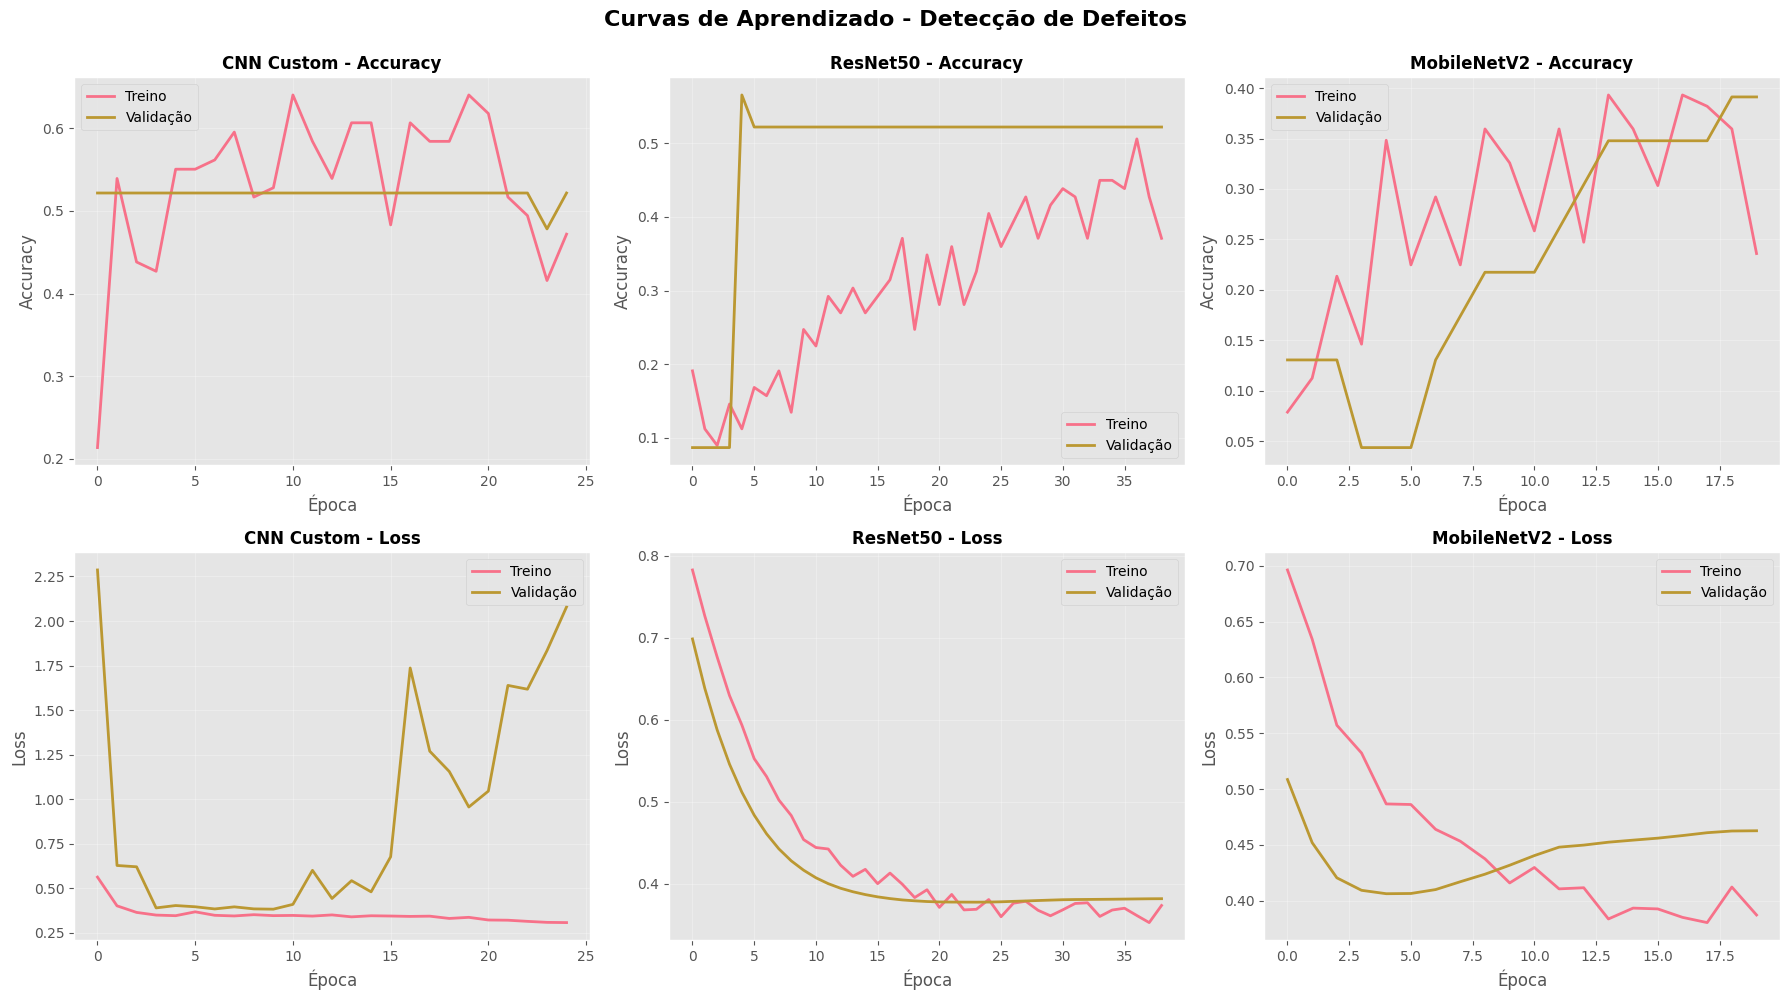


✓ Visualizações salvas!


In [ ]:
# Visualização comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [history_cnn, history_resnet, history_mobile]
names = ['CNN Custom', 'ResNet50', 'MobileNetV2']

for i, (hist, name) in enumerate(zip(histories, names)):
    # Accuracy
    ax = axes[0, i]
    ax.plot(hist.history['accuracy'], label='Treino', linewidth=2)
    ax.plot(hist.history['val_accuracy'], label='Validação', linewidth=2)
    ax.set_title(f'{name} - Accuracy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Época')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Loss
    ax = axes[1, i]
    ax.plot(hist.history['loss'], label='Treino', linewidth=2)
    ax.plot(hist.history['val_loss'], label='Validação', linewidth=2)
    ax.set_title(f'{name} - Loss', fontsize=12, fontweight='bold')
    ax.set_xlabel('Época')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Curvas de Aprendizado - Detecção de Defeitos',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('comparacao_modelos_garrafas.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizações salvas!")

---
## 9. Conclusões

### Resumo do Projeto:

**Problema:** Detecção multi-label de 8 tipos de defeitos em garrafas de Coca-Cola

**Dataset:** 141 imagens reais de garrafas com defeitos variados

**Modelos Implementados:**
1. **CNN Custom**: Arquitetura leve adaptada para o problema
2. **ResNet50**: Transfer learning de modelo profundo
3. **MobileNetV2**: Transfer learning otimizado para eficiência

**Principais Adaptações:**
- ✅ Loss: `binary_crossentropy` (multi-label)
- ✅ Ativação: `sigmoid` na saída (não softmax)
- ✅ Data augmentation adaptado (sem flip horizontal)
- ✅ Métricas multi-label: Hamming Loss, AUC
- ✅ Threshold 0.5 para binarização das previsões

**Diferenças do Problema Original:**
- Dataset REAL (antes era sintético)
- Classificação MULTI-LABEL (antes era single-label)
- 8 classes específicas de defeitos (antes eram genéricas)
- Dataset pequeno (16 vs 800 imagens) - data augmentation crucial!

**Próximos Passos:**
1. Coletar mais dados (dataset muito pequeno)
2. Fine-tuning das camadas superiores dos modelos pré-treinados
3. Ensemble dos 3 modelos
4. Ajuste de threshold por classe
5. Deploy em linha de produção